In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from pyspark import SparkContext
sc = SparkContext()

In [3]:
from pyspark.sql import SQLContext
sqlContent = SQLContext(sc)

from pyspark.sql import Row, DataFrame
from pyspark.sql.types import *

In [4]:
file_data = np.load("../Data/whale_data/whale_data_15mb.np", allow_pickle=True)
len(file_data)

4175

In [5]:
file_rdd = sc.parallelize(file_data.tolist())

In [6]:
schema = StructType([
    StructField("time", TimestampType(), True),
    StructField("species", StringType(), True),
    StructField("site", StringType(), True),
    StructField('rec_no', StringType(), True),
    StructField('bout_i', LongType(), True),
    StructField('peak2peak', DoubleType(), True),
    StructField('MSN', BinaryType(), True),
    StructField('MSP', BinaryType(), True),
    StructField('TPWS1', LongType(), True),
    StructField('MD1', LongType(), True),
    StructField('FD1', LongType(), True),
    StructField('TPWS2', LongType(), True),
    StructField('MD2', LongType(), True),
    StructField('FD2', LongType(), True),
    StructField('TPWS3', LongType(), True),
    StructField('MD3', LongType(), True),
    StructField('FD3', LongType(), True)
])

In [7]:
df = sqlContent.createDataFrame(file_rdd, schema).cache()

In [8]:
df.groupBy("species").count().collect()

[Row(species='Cuviers', count=2238), Row(species='Gervais', count=1937)]

In [9]:
def unpack_array(arr):
    """unpack a byte-array to numpy.ndarray"""
    return np.frombuffer(arr, dtype=np.float64)

In [10]:
def get_msn(row):
    """extract MSN from row as numpy array"""
    return unpack_array(row.MSN)

def get_msp(row):
    """extract MSP from row as numpy array"""
    return unpack_array(row.MSP)

### Waveforms and Spectra

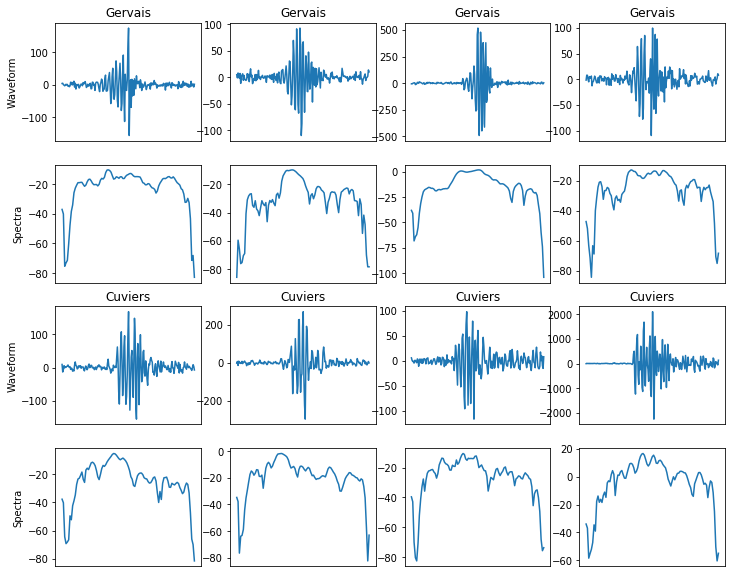

In [11]:
gervais = df.filter(df.species == "Gervais").take(4)
cuviers = df.filter(df.species == "Cuviers").take(4)

plt.figure(figsize=(12, 10))

i = 0
for row in (gervais + cuviers):
    wave_form = get_msn(row)
    spectra = get_msp(row)
    plt.subplot(4, 4, i+1)
    plt.plot(wave_form)
    plt.title(row.species)
    plt.gca().axes.get_xaxis().set_ticks([])
    if i % 4 == 0:
        plt.ylabel("Waveform")
    plt.subplot(4, 4, i+5)
    plt.plot(spectra)
    plt.gca().axes.get_xaxis().set_ticks([])
    if i % 4 == 0:
        plt.ylabel("Spectra")
    i += 1
    if i == 4: i = 8

### Analysis based on Spectra

In [12]:
# principle component analysis - pca

def outer_product(x):
    """compute outer product and indicate which locations in the matrix are undefined"""
    outer_res = np.outer(x, x)
    nan_count = 1 - np.isnan(outer_res)
    return (outer_res, nan_count)

def sum_with_nan(m1, m2):
    """add two pairs and return (matrix, count)"""
    (x1, n1) = m1
    (x2, n2) = m2
    n = n1 + n2
    x = np.nansum(np.dstack((x1, x2)), axis=2)
    return (x, n)

In [13]:
def compute_cov(RDD):
    """input -> input RDD of numpy arrays (all same length)
       computes -> covariance matrix of the vectors"""
    # insert 1 at the beginning of each vector so that the calculation also yields the mean vector
    rdd = RDD.map(lambda v: np.array(np.insert(v, 0, 1), dtype=np.float64))
    
    outer_rdd = rdd.map(outer_product)
    (S, N) = outer_rdd.reduce(sum_with_nan)
    
    E = S[0, 1:]
    NE = np.float64(N[0, 1:])
    MEAN = E / NE
    O = S[1:, 1:]
    NO = np.float64(N[1:, 1:])
    cov_matrix = O / NO - np.outer(MEAN, MEAN)
    var = np.array([cov_matrix[i, i] for i in range(cov_matrix.shape[0])])
    return {
        "E": E,
        "NE": NE,
        "O": O,
        "NO": NO,
        "COV": cov_matrix,
        "MEAN": MEAN,
        "VAR": var
    }

In [14]:
spectra = df.rdd.map(get_msp)
cov_res = compute_cov(spectra)

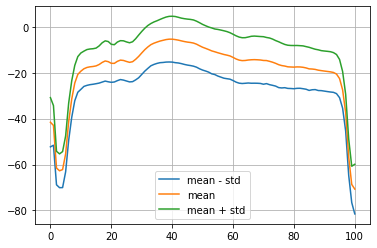

In [15]:
mean = cov_res["MEAN"]
std_dev = np.sqrt(cov_res["VAR"])
plt.plot(mean - std_dev)
plt.plot(mean)
plt.plot(mean + std_dev)
plt.legend(["mean - std", "mean", "mean + std"])
plt.grid()
plt.show()

### PCA of Spectra

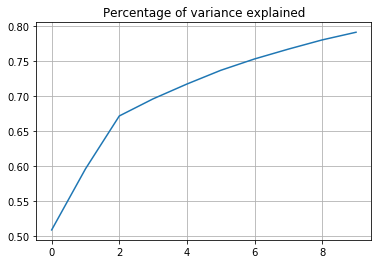

In [16]:
eig_val, eig_vec = np.linalg.eig(cov_res["COV"])
eig_val = eig_val / sum(eig_val)
plt.plot(np.cumsum(eig_val[:10]))
plt.title("Percentage of variance explained")
plt.grid()
plt.show()

### Visualizing first 4 eigen-vectors

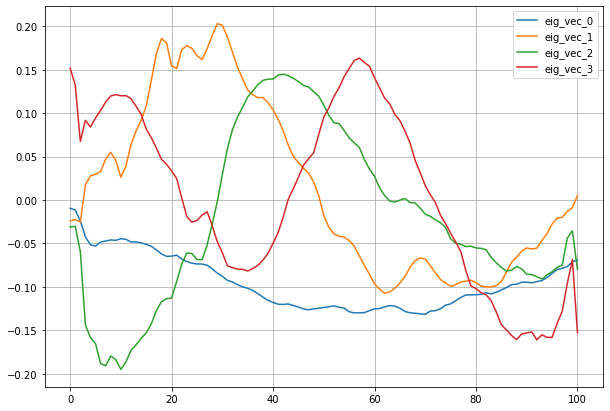

In [17]:
plt.figure(figsize=(10, 7))
for i in range(4):
    plt.plot(eig_vec[:, i], label="eig_vec_"+str(i))
plt.legend()
plt.grid()
plt.show()

### Working with first 10 eigen-vectors

In [18]:
vecs = eig_vec[:, :10]

def cal_stats(row):
    arr = get_msp(row)
    projection = np.dot(arr, vecs)
    rmse = np.std(arr)
    peak2peak = row.peak2peak
    label = 0 if row.species == u"Gervais" else 1
    return np.hstack((projection, [rmse, peak2peak, label]))

In [19]:
trimmed_data = df.rdd.map(cal_stats)
trimmed_data

PythonRDD[34] at RDD at PythonRDD.scala:53

In [20]:
# writing processed data
np_data = np.array(trimmed_data.collect())
np.save(open("processed_data_15mb.npy", "wb"), np_data)

### Projecting top eigen-vectors

In [21]:
gervais = df.filter(df.species == "Gervais")
cuviers = df.filter(df.species == "Cuviers")

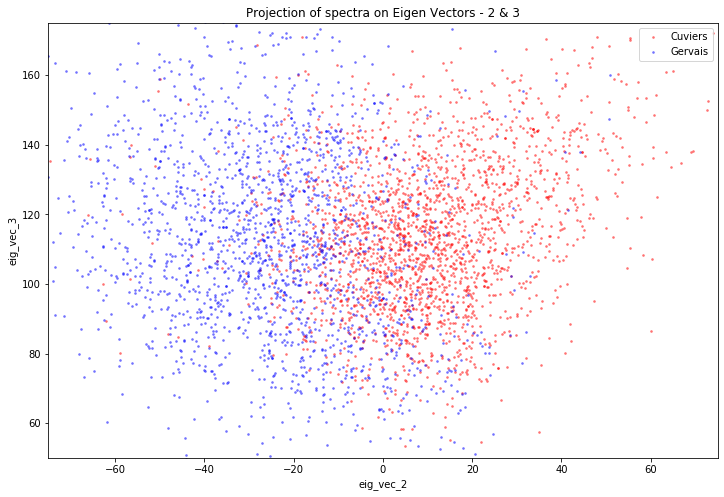

In [22]:
vecs = eig_vec[:, 1:3]

def project_data(row):
    return np.dot(get_msp(row), vecs)

cuviers_projection = np.array(cuviers.rdd.map(project_data).collect())
gervais_projection = np.array(gervais.rdd.map(project_data).collect())

plt.figure(figsize=(12, 8))
plt.scatter(cuviers_projection[:, 0], cuviers_projection[:, 1], c="r", s=3, alpha=0.4)
plt.scatter(gervais_projection[:, 0], gervais_projection[:, 1], c="b", s=3, alpha=0.4)
plt.title("Projection of spectra on Eigen Vectors - 2 & 3")
plt.xlabel("eig_vec_2")
plt.ylabel("eig_vec_3")
plt.legend(["Cuviers", "Gervais"])
plt.xlim([-75, 75])
plt.ylim([50, 175])
plt.show()

### Highlighting Overlap region

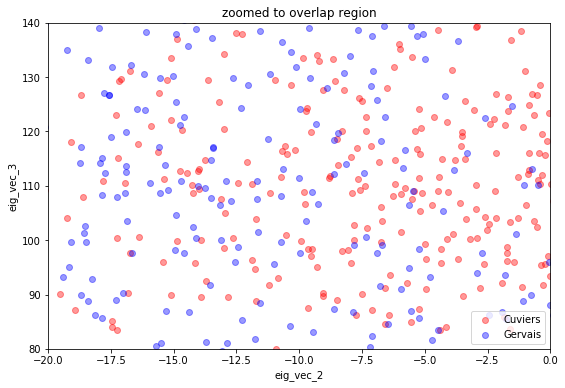

In [23]:
cuviers_projection = np.array(cuviers.sample(False, 0.5).rdd.map(project_data).take(10000))
gervais_projection = np.array(gervais.sample(False, 0.5).rdd.map(project_data).take(10000))

plt.figure(figsize=(9, 6))
plt.scatter(cuviers_projection[:, 0], cuviers_projection[:, 1], c="r", alpha=0.4)
plt.scatter(gervais_projection[:, 0], gervais_projection[:, 1], c="b", alpha=0.4)
plt.title("zoomed to overlap region")
plt.xlabel("eig_vec_2")
plt.ylabel("eig_vec_3")
plt.legend(["Cuviers", "Gervais"], loc="lower right")
plt.xlim([-20, 0])
plt.ylim([80, 140])
plt.show()